In [1]:
from datetime import datetime as dt
import sys
import warnings
warnings.filterwarnings('ignore')

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression

In [3]:
sys.path.append('../src/')
import helper

In [4]:
today = dt.today().isoformat().split("T")[0]
today

'2021-11-25'

In [5]:
datapath = '../data/raw/WA_Fn-UseC_-HR-Employee-Attrition.csv'

In [6]:
ibm = pd.read_csv(datapath)

In [7]:
data_loader = helper.IBMData(datapath, verbose=True)
X, y = data_loader.separate_response


Split X and y...
self.X.shape (1470, 34)
self.y.shape (1470,)


In [8]:
data_pp = helper.PreProcess(X, verbose=True)
data_pp.preprocess_data()


The following categorical_columns have been label encoded: ['BusinessTravel', 'Department', 'EducationField', 'JobRole', 'MaritalStatus', 'Education', 'EnvironmentSatisfaction', 'JobInvolvement', 'JobLevel', 'JobSatisfaction', 'RelationshipSatisfaction', 'StockOptionLevel', 'WorkLifeBalance']

The following categorical_columns have been binarized: ['Gender', 'Over18', 'OverTime']


In [9]:
preprocessed_X = data_pp.pp_X

preproccessed_X_and_y = pd.concat([preprocessed_X, y], axis=1)
preproccessed_X_and_y.shape

(1470, 35)

In [10]:
response_col = 'Attrition'
cat_num_cols = ["Education", "EnvironmentSatisfaction", "JobInvolvement",
                "JobLevel", "JobSatisfaction", "NumCompaniesWorked", "PerformanceRating", 
                "RelationshipSatisfaction", "StockOptionLevel", "TrainingTimesLastYear", "WorkLifeBalance"]

numeric_cols = [col for col in ibm.columns if (type(ibm.loc[0, col]) != str) 
                and (col not in cat_num_cols) 
                and (col != response_col)]
categoricals = [col for col in ibm.columns if col not in numeric_cols and col not in cat_num_cols and col != response_col]

#### Observations
- Certain of the numeric columns look to have uniform distribution 
    - DailyRate
    - Hourly Rate (likely highly colinear & highly correlated to DailyRate
    - Monthly Rate (likely highly colinear & highly correlated to DailyRate)
- Others look to have high skew 
    - Distance from Home
    - Percent Salary Hike
    - Monthly Income
    - Total Working Years
    - Years at Company
    - Years Since Last Promotion
- Bimodal / Multimodal distribution
    - Years in Current Role

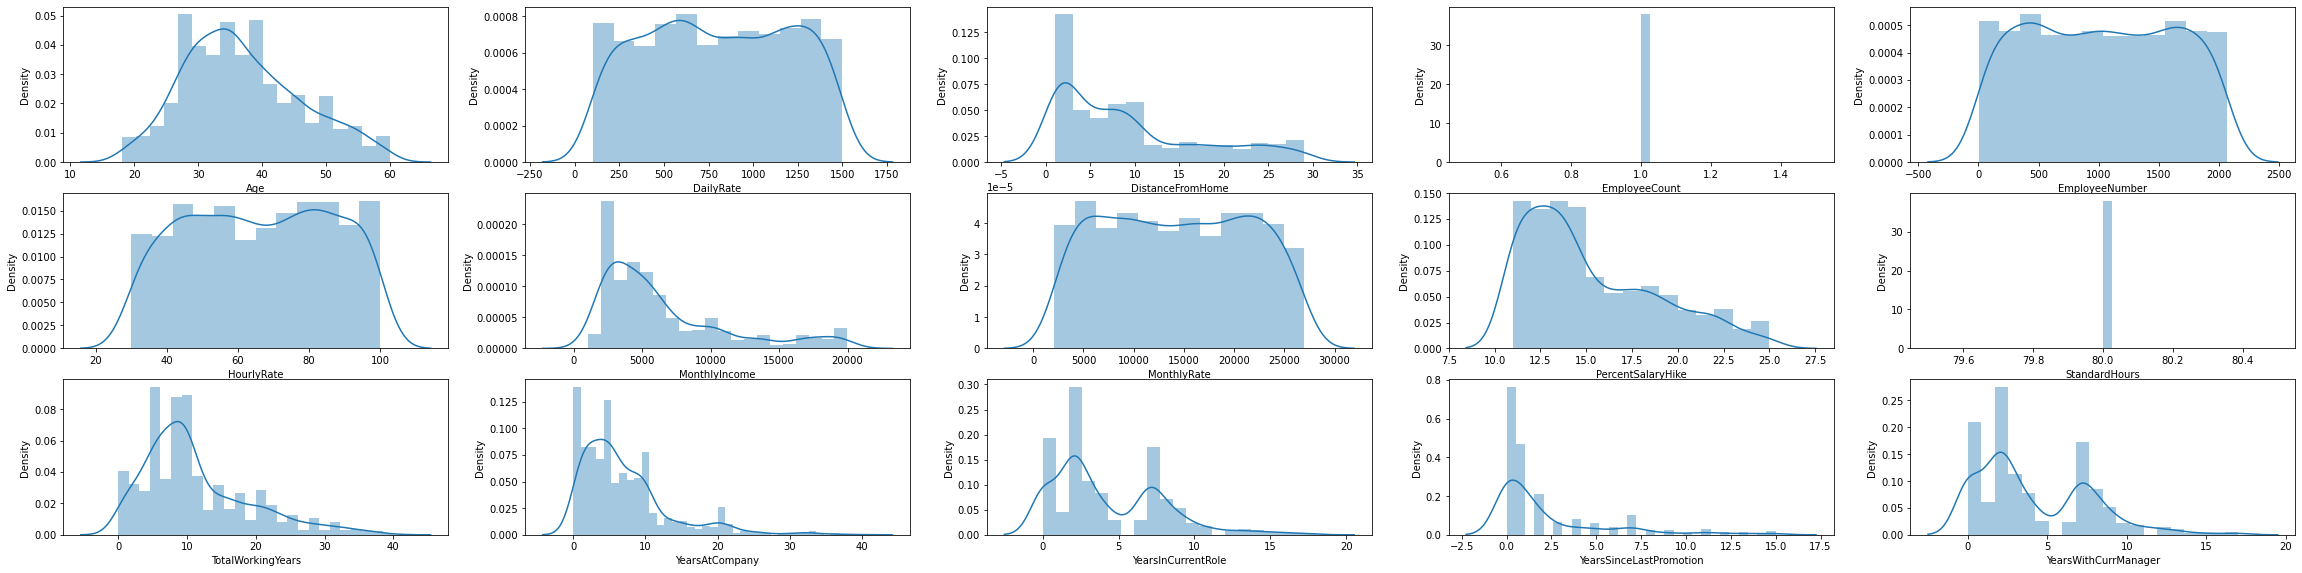

In [11]:
fig = plt.figure(1, figsize=(40, 20))
for i, col in enumerate(numeric_cols):
    fig.add_subplot(6, 5, i + 1)
    sns.distplot(ibm[col].dropna())
plt.show()
fig.savefig(f'../reports/ibm-distplots-{today}.png')

#### Correlation Analysis for Collinearity

In [12]:
corr = preproccessed_X_and_y.corr()

In [41]:
corr.head()

Age  BusinessTravel  DailyRate  Department  \
Age               1.000000        0.024751   0.010661   -0.031882   
BusinessTravel    0.024751        1.000000  -0.004086   -0.009044   
DailyRate         0.010661       -0.004086   1.000000    0.007109   
Department       -0.031882       -0.009044   0.007109    1.000000   
DistanceFromHome -0.001686       -0.024469  -0.004985    0.017225   

                  DistanceFromHome  Education  EducationField  EmployeeCount  \
Age                      -0.001686   0.208034       -0.040873            NaN   
BusinessTravel           -0.024469   0.000757        0.023724            NaN   
DailyRate                -0.004985  -0.016806        0.037709            NaN   
Department                0.017225   0.007996        0.013720            NaN   
DistanceFromHome          1.000000   0.021042        0.002013            NaN   

                  EmployeeNumber  EnvironmentSatisfaction  ...  \
Age                    -0.010145                 0.010146  ...   
BusinessTravel         -0.015578                 0.004174  ...   
DailyRate              -0.050990                 0.018355  ...   
Department             -0.010895                -0.019395  ...   
DistanceFromHome        0.032916                -0.016075  ...   

                  RelationshipSatisfaction  StandardHours  StockOptionLevel  \
Age                               0.053535            NaN          0.037510   
BusinessTravel                   -0.035986            NaN         -0.016727   
DailyRate                         0.007846            NaN          0.042143   
Department                       -0.022414            NaN         -0.012193   
DistanceFromHome                  0.006557            NaN          0.044872   

                  TotalWorkingYears  TrainingTimesLastYear  WorkLifeBalance  \
Age                        0.680381              -0.019621        -0.021490   
BusinessTravel             0.034226               0.015240        -0.011256   
DailyRate                  0.014515               0.002453        -0.037848   
Department                -0.015762               0.036875         0.026383   
DistanceFromHome           0.004628              -0.036942        -0.026556   

                  YearsAtCompany  YearsInCurrentRole  YearsSinceLastPromotion  \
Age                     0.311309            0.212901                 0.216513   
BusinessTravel         -0.014575           -0.011497                -0.032591   
DailyRate              -0.034055            0.009932                -0.033229   
Department              0.022920            0.056315                 0.040061   
DistanceFromHome        0.009508            0.018845                 0.010029   

                  YearsWithCurrManager  
Age                           0.202089  
BusinessTravel               -0.022636  
DailyRate                    -0.026363  
Department                    0.034282  
DistanceFromHome              0.014406  

[5 rows x 34 columns]

In [68]:
from pprint import pprint

In [69]:
collinear_pairs = list()

for i, row in corr.iterrows():
    corr_cols = (np.where(row > 0.6))[0]
    pair = set()
    for j in corr_cols:
        if corr.loc[i, corr.columns[j]] != 1: 
            pair = set([i, corr.columns[j]])
            if pair not in collinear_pairs:
                collinear_pairs.append(pair) 

pprint(collinear_pairs)

[{'Age', 'TotalWorkingYears'},
 {'Department', 'JobRole'},
 {'MonthlyIncome', 'JobLevel'},
 {'TotalWorkingYears', 'JobLevel'},
 {'TotalWorkingYears', 'MonthlyIncome'},
 {'PerformanceRating', 'PercentSalaryHike'},
 {'YearsAtCompany', 'TotalWorkingYears'},
 {'YearsAtCompany', 'YearsInCurrentRole'},
 {'YearsAtCompany', 'YearsSinceLastPromotion'},
 {'YearsWithCurrManager', 'YearsAtCompany'},
 {'YearsWithCurrManager', 'YearsInCurrentRole'}]


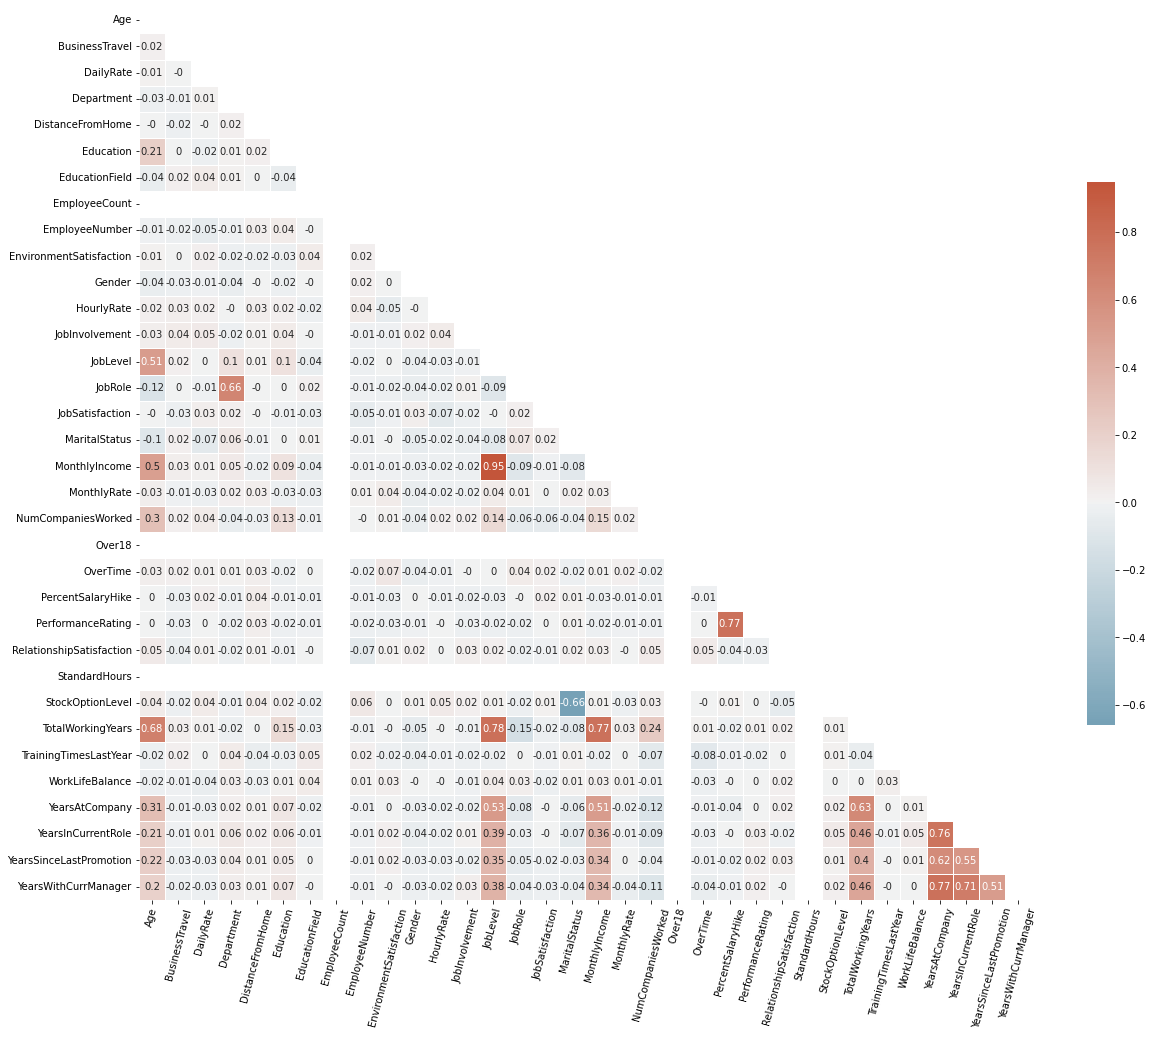

In [39]:
fig2 = plt.figure(1, figsize=(20, 20))

mask = np.triu(np.ones_like(corr, dtype=bool))

sns.heatmap(corr.round(2),
            cbar=True,
            mask=mask,
            annot=True,
            center=0,
            square=True, 
            linewidths=.5, 
            cbar_kws={"shrink": .5},
            cmap=sns.diverging_palette(230, 20, as_cmap=True))
plt.xticks(rotation=75)
plt.show()
fig2.savefig('../reports/figures/corr-heatmap-annot.png')

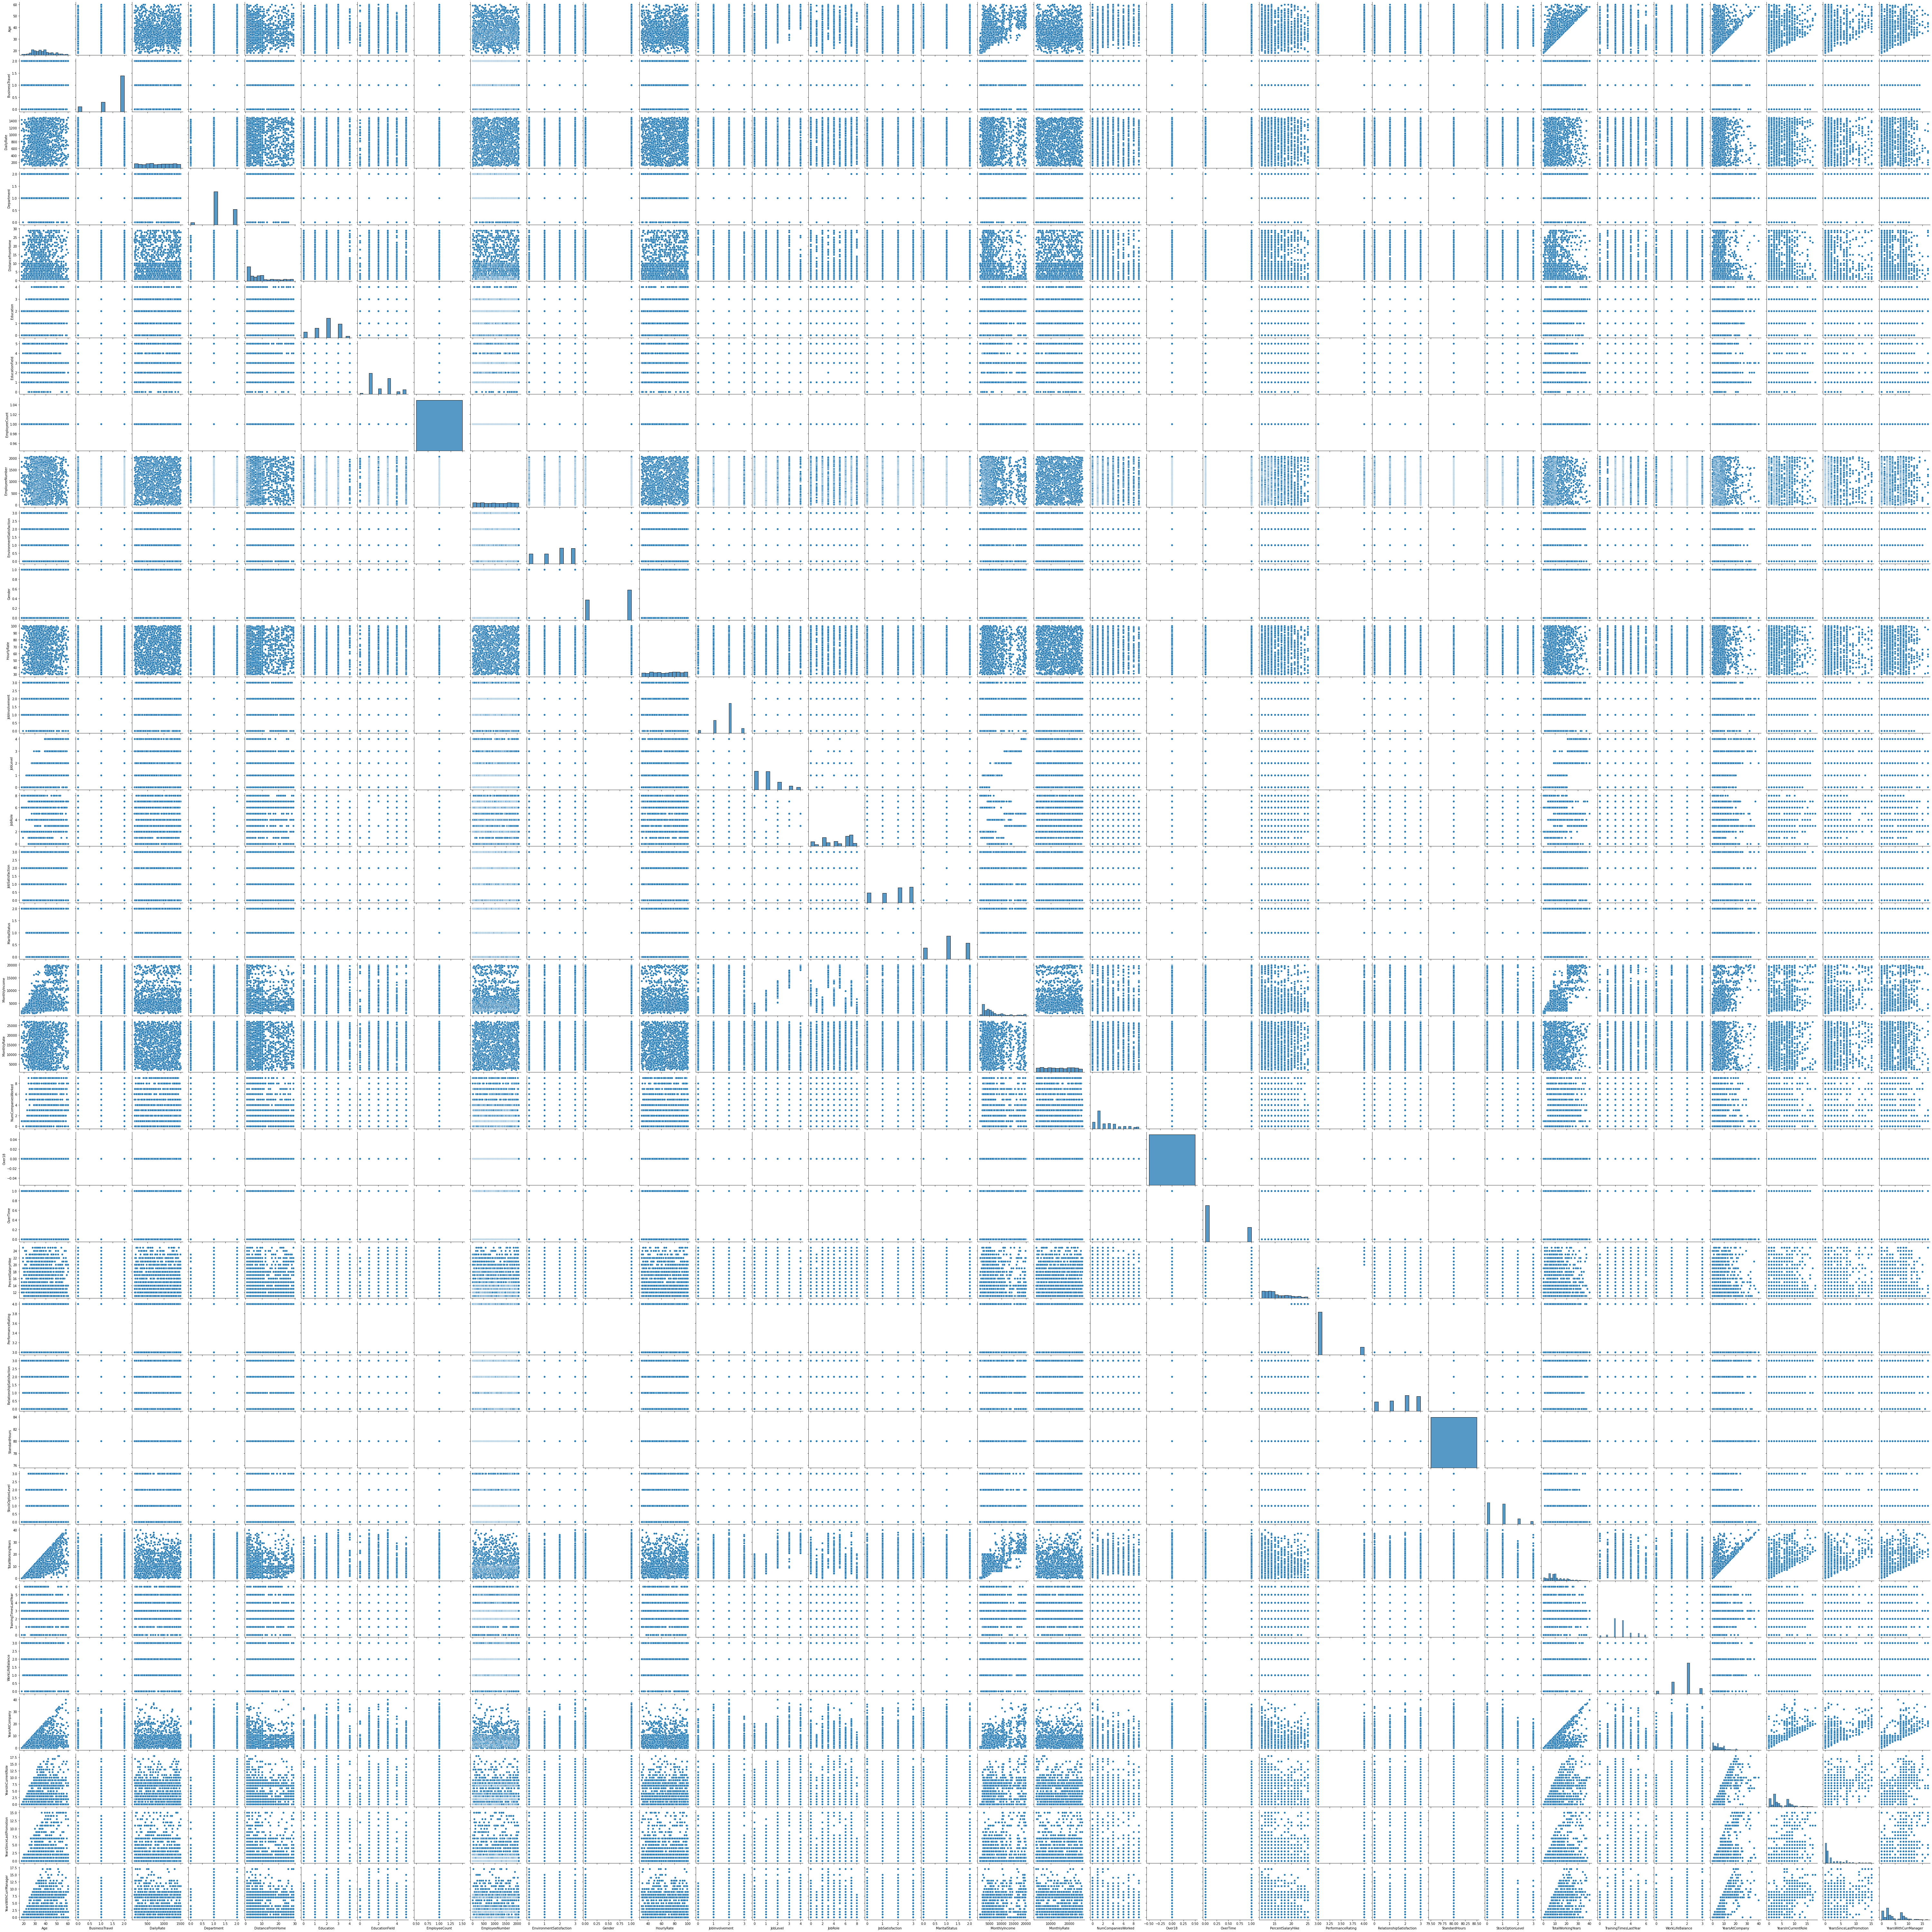

In [18]:
sns.pairplot(preproccessed_X_and_y)

In [ ]:
ibm['StandardHours'].unique()

#### VIF (Variable Inflation Factor) to Measure Multilinearity
- Reference: https://towardsdatascience.com/statistics-in-python-collinearity-and-multicollinearity-4cc4dcd82b3f


**Observations**
- Employee Count is not a relevant feature as shown in the Correlation heatmap as well as the VIF table below.
- Over 18 is not a valuable attribute either 
- Standard hours is 

In [14]:
def calculate_vif(df, features):    
    vif, tolerance = {}, {}
    
    # all the features that you want to examine
    for feature in features:
        # extract all the other features you will regress against
        X = [f for f in features if f != feature]        
        X, y = df[X], df[feature]
        # extract r-squared from the fit
        r2 = LinearRegression().fit(X, y).score(X, y)                
        
        # calculate tolerance
        tolerance[feature] = 1 - r2
        # calculate VIF
        vif[feature] = 1/(tolerance[feature])
    # return VIF DataFrame
    return pd.DataFrame({'VIF': vif, 'Tolerance': tolerance})


In [23]:
vif_df = calculate_vif(preproccessed_X_and_y, preprocessed_X.columns)
multilin_feats = vif_df[vif_df['VIF'] > 10]
multilin_feats.index.tolist()

['EmployeeCount', 'JobLevel', 'MonthlyIncome', 'Over18', 'StandardHours']

### Observations
- There are categorical attributes that are numerically represented, such as: 
    - Education: 1, 2, 3, 4, 5
    - Environment Satisfaction: 1, 2, 3, 4
    - Job Involvement: 1, 2, 3, 4
    - Job Level: 1, 2, 3, 4, 5
    - Job Satisfaction: 1, 2, 3, 4
    - Num Companies Worked: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9
    - Performance Rating: 3, 4
    - Relationship Satisfaction: 1, 2, 3, 4
    - Stock Option Level: 0, 1, 2, 3
    - Training Times Last Year: 0, 1, 2, 3, 4, 5, 6
    - Work Life balance: 1, 2, 3, 4

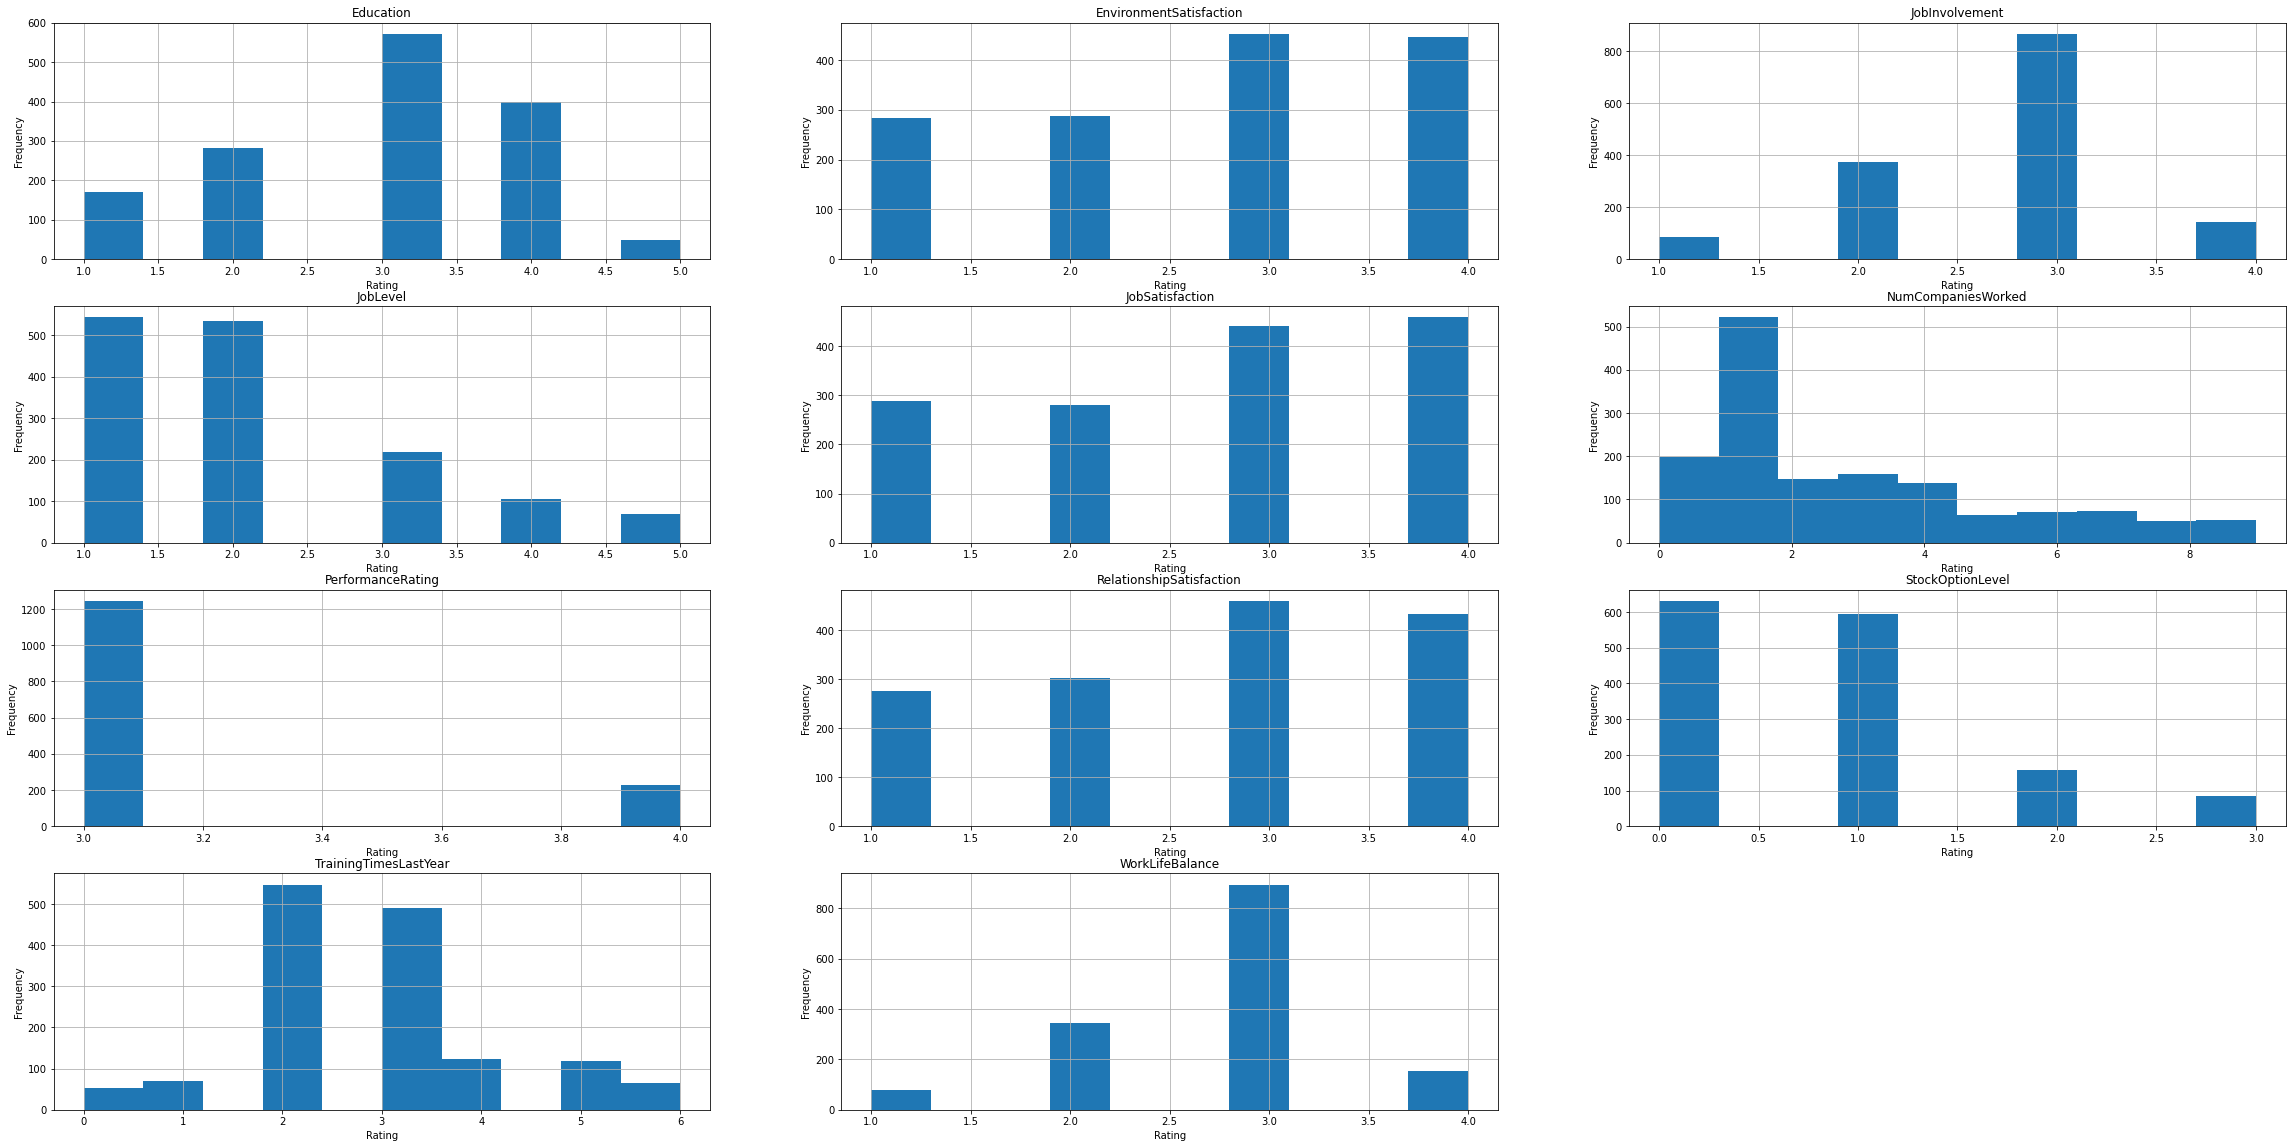

In [15]:
fig = plt.figure(1, figsize=(40, 20))
for i, col in enumerate(cat_num_cols):
    fig.add_subplot(4, 3, i+1)
    ibm[col].hist()
    plt.title(col)
    plt.xlabel('Rating')
    plt.ylabel('Frequency')
plt.show()
fig.savefig(f'../reports/ibm-numeric-categories-{today}.png')

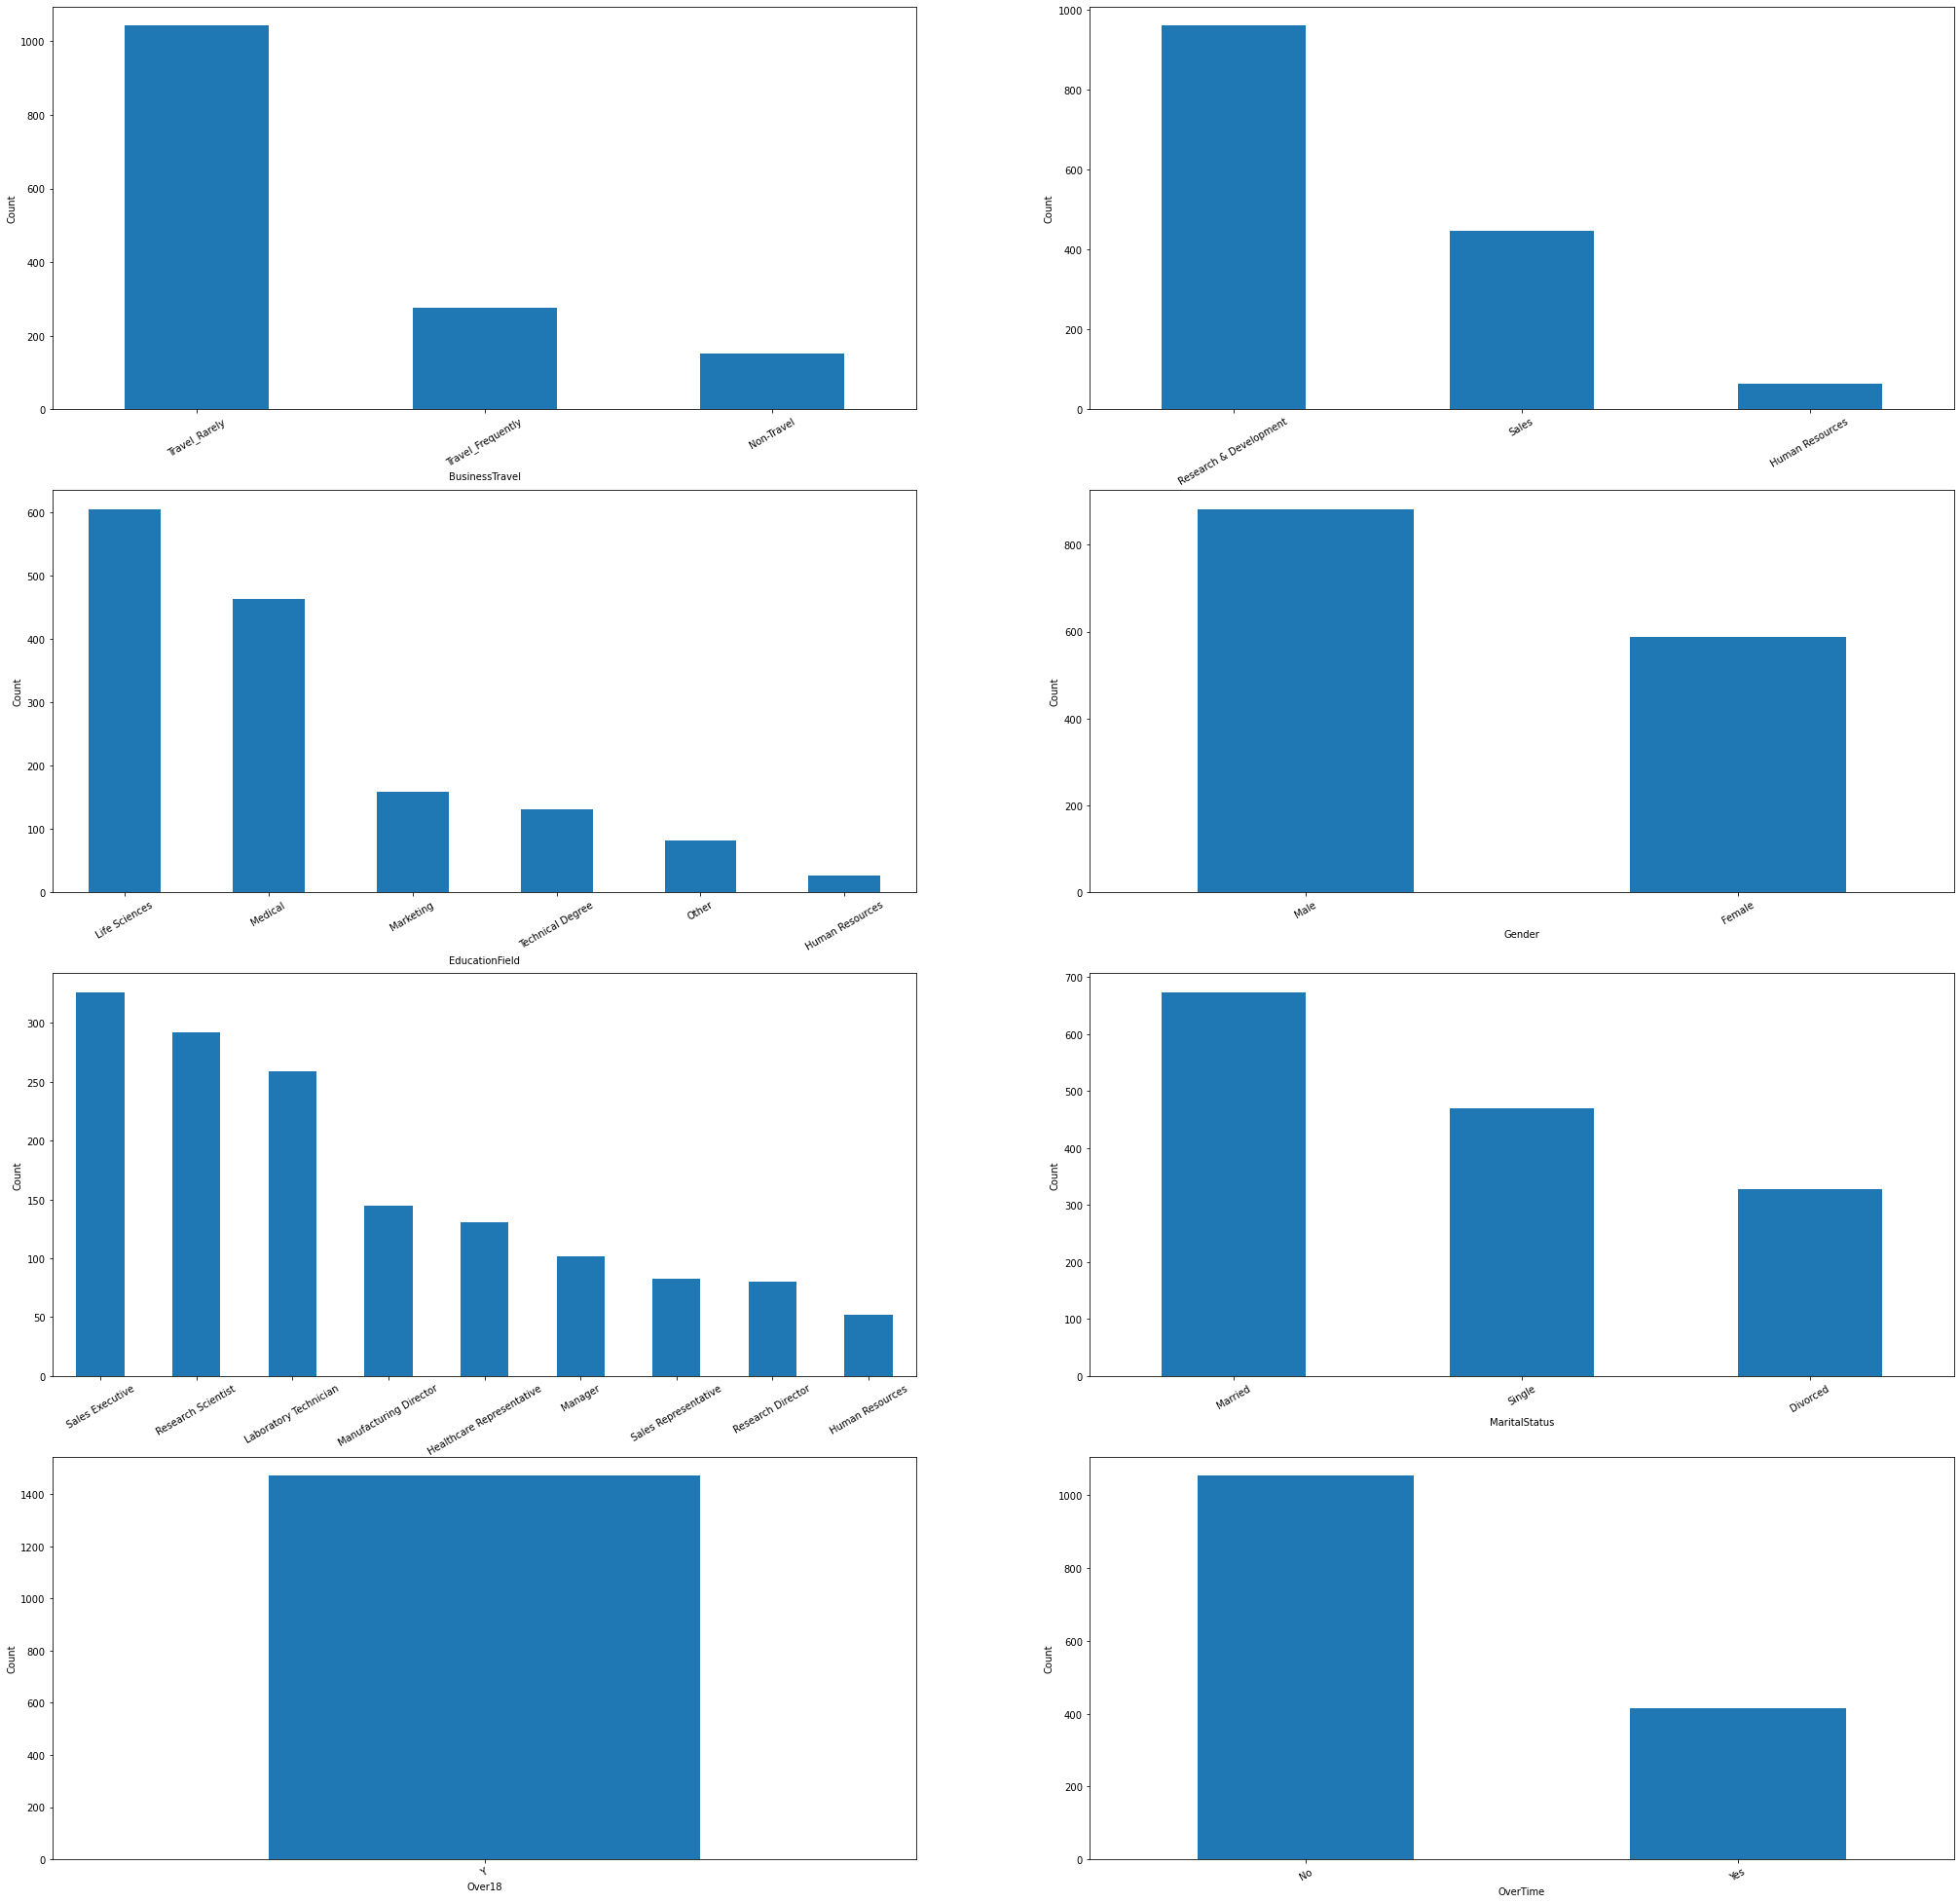

In [16]:
fig = plt.figure(1, figsize=(35, 35))
for i, col in enumerate(categoricals): 
    fig.add_subplot(4, 2, i+1)
    ibm[col].value_counts().plot(kind='bar')
    plt.xticks(rotation=30)
    plt.ylabel('Count')
    plt.xlabel(col)
plt.show()
fig.savefig(f'../reports/ibm-categorical-histograms-{today}.png')